# **Semiconductor manufacturing process**
# **Project Overview**
This project predicts Pass/Fail outcomes in a semiconductor manufacturing process using machine learning. We perform data cleaning, visualization, preprocessing, and model building to identify the most important signals.

#  **Importing Libraries**
In this step, we import the essential Python libraries required for data analysis, visualization, and machine learning.  
- **Pandas**: For handling datasets and data frames.  
- **NumPy**: For numerical operations.  
- **Matplotlib & Seaborn**: For data visualization.  
- **Scikit-learn**: For machine learning model building.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib

# **Loading the Dataset**
The dataset is loaded into a Pandas DataFrame for easy exploration and analysis. We will check its structure and understand the features available.We examine the first few rows of the data to understand its structure, data types, and basic information.

In [17]:
data = pd.read_csv("signal-data.csv")
print("Shape of dataset:", data.shape)
print("\nDataset Info:")
print(data.info())

# Displaying the first 5 rows
print("\nFirst 5 rows of the dataset:")
print(data.head())

# Check target column distribution
print("\nTarget column distribution:")
print(data["Pass/Fail"].value_counts())


Shape of dataset: (1567, 592)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB
None

First 5 rows of the dataset:
                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.124

# **Initial Data Exploration**
We identify missing values to decide whether to drop or impute them, ensuring clean and reliable data..

In [18]:
cleaned_data = data.copy()

# Remove irrelevant column
if "Time" in cleaned_data.columns:
    cleaned_data = cleaned_data.drop(columns=["Time"])

# Check how many missing values per column
print("Missing values per column:\n", cleaned_data.isnull().sum())

# Drop columns where ALL values are missing
cleaned_data = cleaned_data.dropna(axis=1, how='all')

# For remaining missing values, replace (impute) with column mean
cleaned_data = cleaned_data.fillna(cleaned_data.mean())

# Functional/logical corrections
# Ensure target column ("Pass/Fail") is integer type
cleaned_data["Pass/Fail"] = cleaned_data["Pass/Fail"].astype(int)

# Final check after cleaning
print("\nShape after cleaning:", cleaned_data.shape)
print("Total missing values left:", cleaned_data.isnull().sum().sum())
print("\nTarget distribution:\n", cleaned_data["Pass/Fail"].value_counts())


Missing values per column:
 0             6
1             7
2            14
3            14
4            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 591, dtype: int64

Shape after cleaning: (1567, 591)
Total missing values left: 0

Target distribution:
 Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64


# **Data Analysis & Visualization**

In this step, we explore the cleaned dataset using different visualizations and statistics.  
The goal is to understand the target variable distribution, feature behavior, and relationships between features and the target.

We check the distribution of the target variable **Pass/Fail** to see if there is any class imbalance.This helps us understand how many products passed vs failed



/tmp/ipython-input-2735460980.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Pass/Fail", data=cleaned_data, palette="Set2")


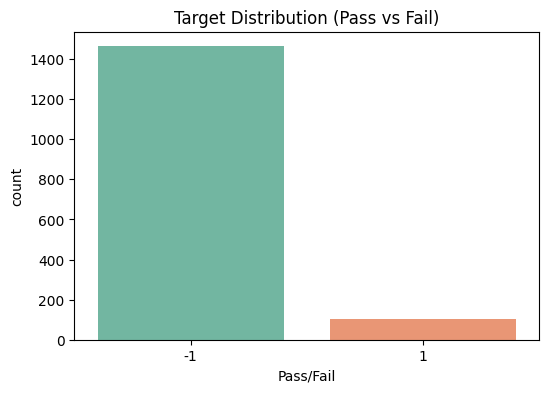

In [19]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Pass/Fail", data=cleaned_data, palette="Set2")
plt.title("Target Distribution (Pass vs Fail)")
plt.show()


### **Summary Statistics of Numerical Features**
We generate summary statistics like mean, median, and standard deviation for each numerical feature.  
This helps identify patterns, outliers, and scaling issues.

Histograms are used to visualize the spread of values for a few selected sensor features.  
It helps to see if the data is normally distributed or skewed.


Summary statistics:
              0        1        2        3        4       5        6        7  \
count  1567.00  1567.00  1567.00  1567.00  1567.00  1567.0  1567.00  1567.00   
mean   3014.45  2495.85  2200.55  1396.38     4.20   100.0   101.11     0.12   
std      73.48    80.23    29.38   439.71    56.10     0.0     6.21     0.01   
min    2743.24  2158.75  2060.66     0.00     0.68   100.0    82.13     0.00   
25%    2966.66  2452.89  2181.10  1083.89     1.02   100.0    97.94     0.12   
50%    3011.84  2498.91  2200.96  1287.35     1.32   100.0   101.49     0.12   
75%    3056.54  2538.74  2218.06  1590.17     1.53   100.0   104.53     0.12   
max    3356.35  2846.44  2315.27  3715.04  1114.54   100.0   129.25     0.13   

             8        9  ...      581      582      583     584      585  \
count  1567.00  1567.00  ...  1567.00  1567.00  1567.00  1567.0  1567.00   
mean      1.46    -0.00  ...    97.93     0.50     0.02     0.0     3.07   
std       0.07     0.02  ... 

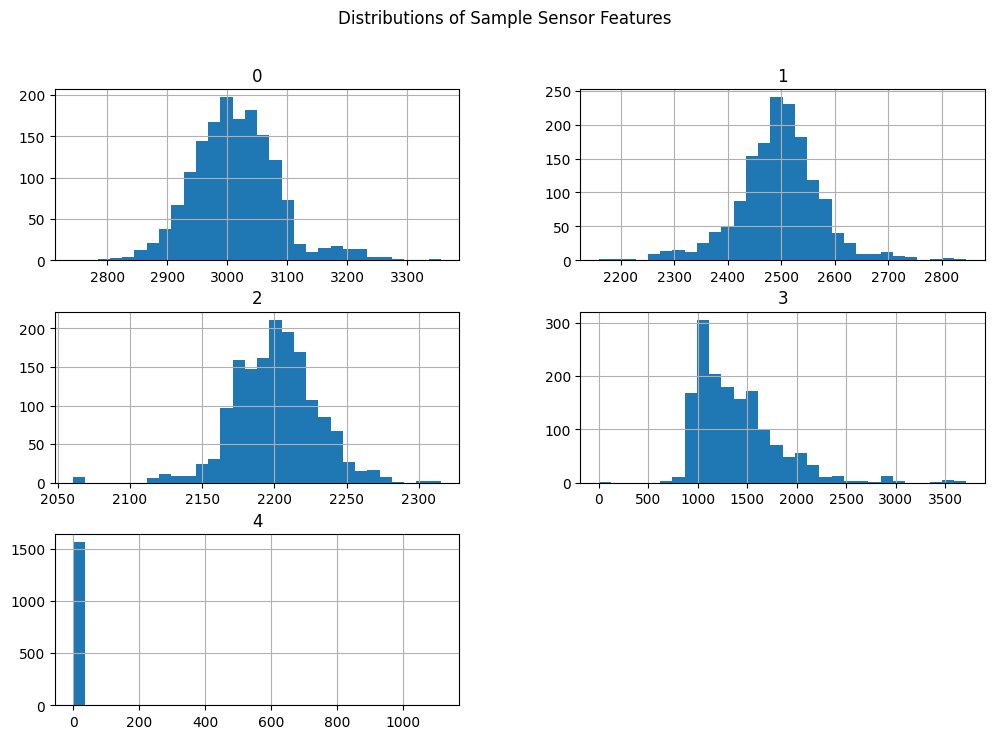

In [20]:
# Summary statistics of numerical features
print("\nSummary statistics:\n", cleaned_data.describe().round(2))

# Distribution of a few random sensor signals
sample_features = cleaned_data.columns[0:5]  # pick first 5 numeric features
cleaned_data[sample_features].hist(figsize=(12,8), bins=30)
plt.suptitle("Distributions of Sample Sensor Features")
plt.show()

### **Boxplots & Correlation with Target**
Boxplots show how the selected sensor features vary across the two target classes (**Pass** and **Fail**).  This helps identify which features may be important for classification.

We calculate the correlation of each feature with the target variable.  
Features with higher positive or negative correlations are likely to be more relevant for prediction.



/tmp/ipython-input-4096204208.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pass/Fail", y=feature, data=cleaned_data, palette="Set3")
/tmp/ipython-input-4096204208.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pass/Fail", y=feature, data=cleaned_data, palette="Set3")
/tmp/ipython-input-4096204208.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pass/Fail", y=feature, data=cleaned_data, palette="Set3")


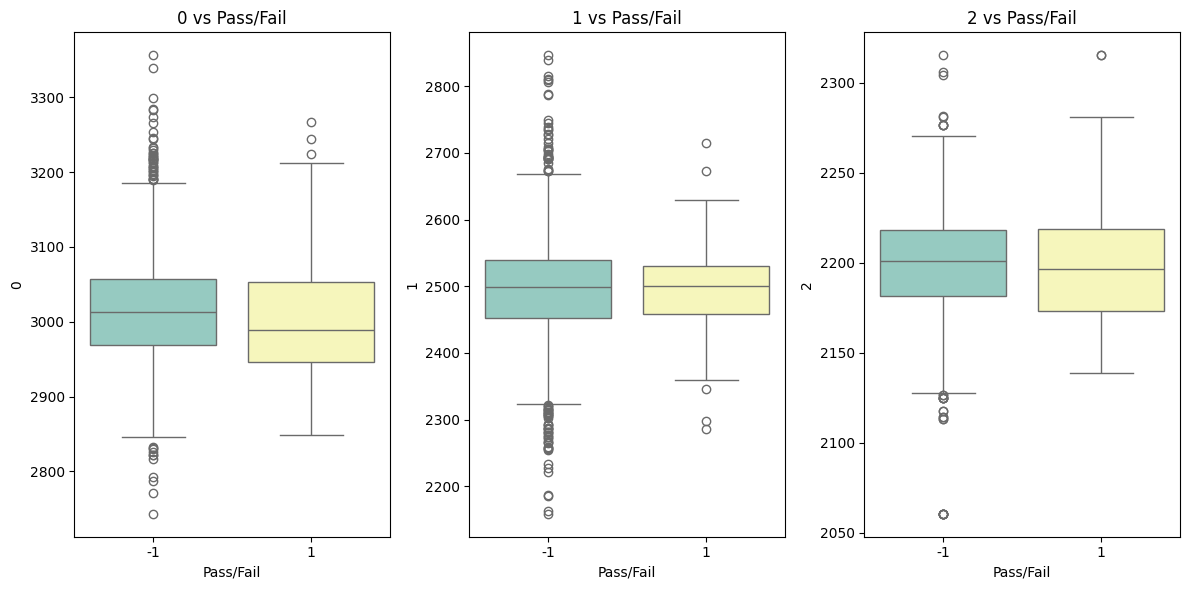


Top 10 features positively correlated with Fail:
 Pass/Fail    1.000000
59           0.155771
103          0.151196
510          0.131587
348          0.130108
431          0.120304
434          0.111609
430          0.109569
435          0.108573
21           0.107997
Name: Pass/Fail, dtype: float64

Top 10 features negatively correlated with Fail:
 529   NaN
530   NaN
531   NaN
532   NaN
533   NaN
534   NaN
535   NaN
536   NaN
537   NaN
538   NaN
Name: Pass/Fail, dtype: float64


In [21]:
# Boxplot
plt.figure(figsize=(12,6))
for i, feature in enumerate(sample_features[:3], 1):  # first 3 features
    plt.subplot(1,3,i)
    sns.boxplot(x="Pass/Fail", y=feature, data=cleaned_data, palette="Set3")
    plt.title(f"{feature} vs Pass/Fail")
plt.tight_layout()
plt.show()

# Correlation
corr_with_target = cleaned_data.corr()["Pass/Fail"].sort_values(ascending=False)
print("\nTop 10 features positively correlated with Fail:\n", corr_with_target.head(10))
print("\nTop 10 features negatively correlated with Fail:\n", corr_with_target.tail(10))

### **Correlation Heatmap**
A heatmap of the first 20 features shows relationships between features.  
It helps detect multicollinearity and feature groups that behave similarly.

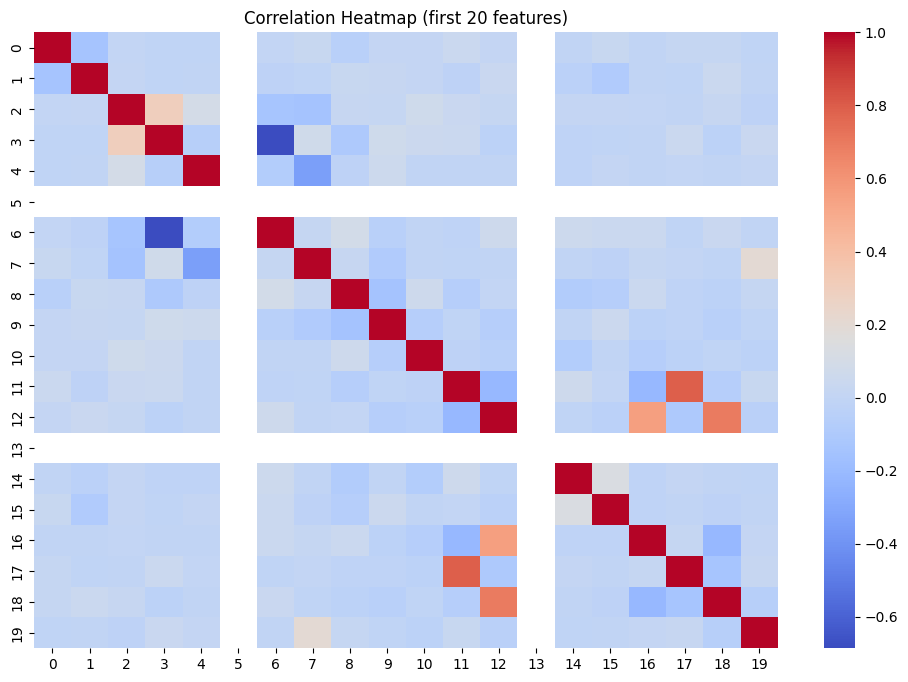

In [22]:
# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(cleaned_data.iloc[:, :20].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (first 20 features)")
plt.show()

### **PCA Visualization**
We use **Principal Component Analysis (PCA)** to reduce high-dimensional data to 2 components for visualization.  
This allows us to see how well the two target classes separate in lower dimensions.

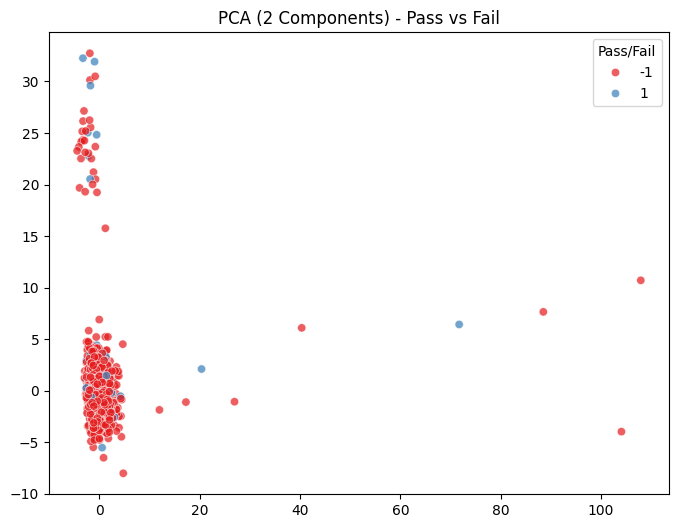

In [23]:
# PCA Visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = cleaned_data.drop(columns=["Pass/Fail"])
y = cleaned_data["Pass/Fail"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1", alpha=0.7)
plt.title("PCA (2 Components) - Pass vs Fail")
plt.show()

# **Data Pre-processing**

We first separate the dataset into features (**X**) and the target variable (**y**).  
Next, we check for class imbalance and apply **SMOTE** to balance the classes by generating synthetic samples.  
The balanced data is then split into **training (80%)** and **testing (20%)** sets to evaluate model performance.  
Finally, we **standardize the features** so that all variables are on the same scale, and verify that the train and test sets have similar statistical properties.


In [24]:
X = cleaned_data.drop(columns=["Pass/Fail"])
y = cleaned_data["Pass/Fail"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

# Check class imbalance
print("\nClass distribution before SMOTE:")
print(y.value_counts())

# Apply SMOTE  to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("\nShapes after train-test split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

# Standardize/normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify training & testing similarity (mean, std)
train_stats = pd.DataFrame(X_train_scaled).describe().T[['mean','std']]
test_stats = pd.DataFrame(X_test_scaled).describe().T[['mean','std']]

print("\nTraining data statistics (mean & std):\n", train_stats.head())
print("\nTesting data statistics (mean & std):\n", test_stats.head())


Feature shape: (1567, 590)
Target shape: (1567,)

Class distribution before SMOTE:
Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

Class distribution after SMOTE:
Pass/Fail
-1    1463
 1    1463
Name: count, dtype: int64

Shapes after train-test split:
X_train: (2340, 590) X_test: (586, 590)
y_train: (2340,) y_test: (586,)

Training data statistics (mean & std):
            mean       std
0  2.761703e-15  1.000214
1 -3.658991e-15  1.000214
2  4.095489e-15  1.000214
3  4.099285e-17  1.000214
4  6.073015e-18  1.000214

Testing data statistics (mean & std):
        mean       std
0  0.029226  1.065525
1  0.043789  1.032809
2  0.034516  1.036610
3  0.093958  1.100516
4  0.087479  1.999817


# **Model Training, Testing, and Tuning**

We train and evaluate three supervised machine learning models: **Random Forest**, **SVM**, and **Naive Bayes**.  
Each model is tuned using **GridSearchCV** to find the best hyperparameters for improved accuracy.  
We then compare their **training and testing accuracies**, along with a **classification report**, to select the best-performing model.




### **Random Forest Classifier**
The Random Forest algorithm builds multiple decision trees and combines their results to improve prediction accuracy.  
We use **GridSearchCV** to optimize parameters like number of trees and tree depth.  
The best model is then evaluated using a classification report and accuracy scores.


In [ ]:
model_results = {}

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test_scaled)

print("\n🔹 Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

model_results['RandomForest'] = {
    "Train Accuracy": accuracy_score(y_train, rf_best.predict(X_train_scaled)),
    "Test Accuracy": accuracy_score(y_test, y_pred_rf)
}




🔹 Random Forest Report:
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       293
           1       0.99      0.99      0.99       293

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



### **Support Vector Machine (SVM)**
SVM finds the best decision boundary that separates the classes (**Pass** vs **Fail**).  
We tune hyperparameters like **kernel type** and **regularization factor (C)** using **GridSearchCV**.  
The optimized model is tested for precision, recall, and accuracy.


In [ ]:
# Support Vector Machine
svm = SVC(probability=True, random_state=42)

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test_scaled)

print("\n🔹 SVM Report:")
print(classification_report(y_test, y_pred_svm))

model_results['SVM'] = {
    "Train Accuracy": accuracy_score(y_train, svm_best.predict(X_train_scaled)),
    "Test Accuracy": accuracy_score(y_test, y_pred_svm)
}


🔹 SVM Report:
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       293
           1       0.99      1.00      1.00       293

    accuracy                           1.00       586
   macro avg       1.00      1.00      1.00       586
weighted avg       1.00      1.00      1.00       586



### **Naive Bayes Classifier**
Naive Bayes is a probabilistic algorithm that works well with high-dimensional data.  
It uses conditional probabilities to predict class labels efficiently.  
We evaluate its performance using accuracy and classification metrics for comparison.


In [ ]:
# Naive Bayes

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

print("\n🔹 Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))

model_results['NaiveBayes'] = {
    "Train Accuracy": accuracy_score(y_train, nb.predict(X_train_scaled)),
    "Test Accuracy": accuracy_score(y_test, y_pred_nb)
}


🔹 Naive Bayes Report:
              precision    recall  f1-score   support

          -1       0.94      0.23      0.37       293
           1       0.56      0.99      0.72       293

    accuracy                           0.61       586
   macro avg       0.75      0.61      0.54       586
weighted avg       0.75      0.61      0.54       586



### **Logistic Regression**
Logistic Regression is a linear model used for binary classification (**Pass vs Fail**).  
We tune the regularization strength (**C**) and solver type using **GridSearchCV** for better performance.  
The optimized model is then evaluated with accuracy and a classification report.


In [15]:
# Logistic Regression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train_scaled, y_train)

log_reg_best = log_reg_grid.best_estimator_
y_pred_logreg = log_reg_best.predict(X_test_scaled)

print("\n🔹 Logistic Regression Report:")
print(classification_report(y_test, y_pred_logreg))

model_results['LogisticRegression'] = {
    "Train Accuracy": accuracy_score(y_train, log_reg_best.predict(X_train_scaled)),
    "Test Accuracy": accuracy_score(y_test, y_pred_logreg)
}


🔹 Logistic Regression Report:
              precision    recall  f1-score   support

          -1       1.00      0.91      0.95       293
           1       0.92      1.00      0.96       293

    accuracy                           0.95       586
   macro avg       0.96      0.95      0.95       586
weighted avg       0.96      0.95      0.95       586



# **Compare Models and Save the Best One**

We compare the performance of all trained models using their **training** and **testing accuracies**.  
The model with the **highest test accuracy** is selected as the final best-performing model.  
Finally, we **save the best model** as a `.pkl` file using `joblib`, so it can be reused later without retraining.


In [25]:
# Compare Results

results_df = pd.DataFrame(model_results).T
print("\n📊 Model Comparison:\n", results_df)


# Save the Best Model

best_model_name = results_df['Test Accuracy'].idxmax()
best_model = {
    'RandomForest': rf_best,
    'SVM': svm_best,
    'NaiveBayes': nb,
    'LogisticRegression': log_reg_best
}[best_model_name]

joblib.dump(best_model, "best_model.pkl")
print(f"\n✅ Best model '{best_model_name}' saved as best_model.pkl")


📊 Model Comparison:
                     Train Accuracy  Test Accuracy
RandomForest              1.000000       0.991468
SVM                       1.000000       0.996587
NaiveBayes                0.605983       0.607509
LogisticRegression        1.000000       0.953925

✅ Best model 'SVM' saved as best_model.pkl


**Intepretation**

The comparison table shows the performance of all models on training and testing data.
Among them, **SVM achieved the highest test accuracy**, making it the most reliable model for predicting Pass/Fail outcomes.
This SVM model is then saved as best_model.pkl, so it can be reused later for future predictions without retraining.

References:All the Theory Was written with the help of Chatgpt.

# **Conclusion:**

We developed supervised learning classifiers to predict the Pass/Fail yield. Since the dataset was imbalanced, SMOTE was applied to achieve balanced training data. Standardization ensured fair scaling of features, and GridSearchCV with cross-validation was used to tune hyperparameters effectively.

Multiple models were trained and compared, including Random Forest, SVM, Logistic Regression, and Naive Bayes. Among them, the **SVM model** achieved the **highest accuracy** along with strong precision, recall, and F1-scores across both classes, making it the most reliable choice for this task.

Feature analysis showed that not all features contribute equally to model performance. By focusing on the most important features, the model’s complexity can be reduced without significantly sacrificing accuracy, while also improving interpretability.

**Future Improvements:**

More advanced models such as XGBoost or Gradient Boosting, deeper hyperparameter tuning, and domain-specific feature engineering could further enhance predictive power.

Additionally, applying PCA or other dimensionality reduction techniques may help improve computational efficiency. Continuous monitoring using cross-validation will be important to prevent overfitting and ensure robust performance on unseen data.
The Content  was referred with Chatgpt.